# Decision Tree on Yearly Aggregates
<a id='top'></a>

<a href=#readdata>Read Data</a>  

<a href=#features>Feature Selection</a>

<a href=#dt>Decision Tree</a>

<a href=#feature_importance>Feature Importance</a>

<a href=#balancedata>Balance Data</a>

<a href=#dt_rebalance>Decision Tree on Re-Balance Data</a>

<a href=#plot>Plot ROC Curve</a>

<a href=#verify_unbalanced>Verify on Unbalanced Dataset</a>

<a href=#re_train>Re-Train Optimal Tree on Unbalanced data</a>

<a href=#feature_importance_final>Feature Importance on Final Model</a>

<a href=#lift_chart_final>Lift Chart</a>

<a href=#confusionmatrixplot>Confusion Matrix Plot</a>

<a href=#bottom>Bottom</a>


In [1]:
# Ignore 'dask' warning
import pandas as pd
import gcsfs
from google.cloud import storage
from pandas import DataFrame
from IPython.display import HTML
from google.cloud.storage import Blob
import datalab.storage as gcs_datalab
from datetime import date
import numpy as np

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.utils import resample
from sklearn import preprocessing
from scipy.stats import sem
import pickle

from matplotlib import pyplot
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
import scikitplot as skplt
import itertools

<a id='readdata'></a>
# Read Yearly Aggregated Data 
<a href=#top>Top</a>

In [2]:
# Setting up constants. All required
project = 'graydon-moving-indicator'
bucket_name = 'graydon-data'

# Initializing bucket
fs = gcsfs.GCSFileSystem(project='graydon-moving-indicator')
gcs = storage.Client()
bucket = gcs.get_bucket(bucket_name)


In [3]:

# Post-aggregation
def create_dict_types_aggregated_data():
    # Setting up dictionary of column types for the aggregated dataset
    dtype={ 
        'id_company'  :np.float64,
        'id_branch'    :np.int64, 
        'code_sbi_2'         : np.float64, 
        'has_relocated':bool,
        'has_relocated_next_year ' : bool,
        'has_name_change' : bool,
        'qty_address_mutations_total' :np.float64,
        'ratio_operating_result_consolidated_operating_result': np.float64,
        'ratio_revenue_consolidated_revenue': np.float64,
        'qty_green_flags'   :np.float64,
        'qty_orange_flags'   :np.float64,
        'qty_red_flags'   :np.float64,
        'A'   :np.float64,
        'AA'   :np.float64,
        'AAA'   :np.float64,
        'B'   :np.float64,
        'BB'   :np.float64,
        'BBB'   :np.float64,
        'C'   :np.float64,
        'CC'   :np.float64,
        'CCC'   :np.float64,
        'D'   :np.float64,
        'NR'   :np.float64,
        'code_legal_form_group_1':  np.int64,
        'code_legal_form_group_2':  np.int64,
        'SBI_group_1':  np.int64,
        'SBI_group_2':  np.int64,
        'company_age'   :np.float64,
        'years_since_last_amt_consolidated_operating_result'   :np.float64,
        'years_since_last_amt_consolidated_revenue'   :np.float64,
        'years_since_last_amt_operating_result'   :np.float64,
        'years_since_last_qty_employees'   :np.float64,
        'years_since_last_amt_revenue'   :np.float64,
        'delta_qty_employees'   :np.float64,
        'delta_qty_issued_credit_reports'   :np.float64,
        'delta_score_payment_assessment'   :np.float64,
        'SBI_has_changed' : bool,
        'unique_id' : object,
        'code_legal_form_has_changed ' : bool,
        'is_discontinued_any ' : bool,
        'has_financial_calamity ' : bool,
        'mean_amt_consolidated_operating_result'   :np.float64,
        'mean_amt_consolidated_revenue'   :np.float64,
        'mean_amt_operating_result'   :np.float64,
        'mean_amt_revenue'   :np.float64,
        'mean_qty_employees'   :np.float64,
        'mean_qty_issued_credit_reports'   :np.float64,
        'mean_score_payment_assessment'   :np.float64,
        'mean_score_pd'   :np.float64,
        'qty_address_mutations_year'   :np.float64,
        'qty_started_names_year'   :np.float64,
        'qty_stopped_names_year'   :np.float64,
        'qty_board_changes_year'   :np.float64,
        'variance_qty_employees'   :np.float64,
        'variance_qty_issued_credit_reports'   :np.float64,
        'variance_score_payment_assessment'   :np.float64,
        'variance_score_pd'   :np.float64
      }
    return dtype

def create_dict_types_aggregated_data2017():
    dtype2017={ 
        'id_company'  :np.float64,
        'id_branch'    :np.int64, 
        'code_sbi_2'         : np.float64, 
        'has_relocated_next_yearC' : bool,
        'has_name_change' : bool,
        'qty_address_mutations_total' :np.float64,
        'ratio_operating_result_consolidated_operating_result': np.float64,
        'ratio_revenue_consolidated_revenue': np.float64,
        'qty_green_flags'   :np.float64,
        'qty_orange_flags'   :np.float64,
        'qty_red_flags'   :np.float64,
        'A'   :np.float64,
        'AA'   :np.float64,
        'AAA'   :np.float64,
        'B'   :np.float64,
        'BB'   :np.float64,
        'BBB'   :np.float64,
        'C'   :np.float64,
        'CC'   :np.float64,
        'CCC'   :np.float64,
        'D'   :np.float64,
        'NR'   :np.float64,
        'code_legal_form_group_1':  np.int64,
        'code_legal_form_group_2':  np.int64,
        'SBI_group_1':  np.int64,
        'SBI_group_2':  np.int64,
        'company_age'   :np.float64,
        'years_since_last_amt_consolidated_operating_result'   :np.float64,
        'years_since_last_amt_consolidated_revenue'   :np.float64,
        'years_since_last_amt_operating_result'   :np.float64,
        'years_since_last_qty_employees'   :np.float64,
        'years_since_last_amt_revenue'   :np.float64,
        'delta_qty_employees'   :np.float64,
        'delta_qty_issued_credit_reports'   :np.float64,
        'delta_score_payment_assessment'   :np.float64,
        'SBI_has_changed' : bool,
        'unique_id' : object,
        'code_legal_form_has_changed ' : bool,
        'is_discontinued_any ' : bool,
        'has_financial_calamity ' : bool,
        'mean_amt_consolidated_operating_result'   :np.float64,
        'mean_amt_consolidated_revenue'   :np.float64,
        'mean_amt_operating_result'   :np.float64,
        'mean_amt_revenue'   :np.float64,
        'mean_qty_employees'   :np.float64,
        'mean_qty_issued_credit_reports'   :np.float64,
        'mean_score_payment_assessment'   :np.float64,
        'mean_score_pd'   :np.float64,
        'qty_address_mutations_year'   :np.float64,
        'qty_started_names_year'   :np.float64,
        'qty_stopped_names_year'   :np.float64,
        'qty_board_changes_year'   :np.float64,
        'variance_qty_employees'   :np.float64,
        'variance_qty_issued_credit_reports'   :np.float64,
        'variance_score_payment_assessment'   :np.float64,
        'variance_score_pd'   :np.float64
      }
    return dtype2017

def create_parse_dates_list_aggregated_data():
    # Setting up dictionary of column types for the aggregated dataset
    parse_dates= ['date_month', 'years_in_current_location']
    return parse_dates

def create_basetable(year_list, dir_prefix = ''):
    """ Reads a whole year of data from the already aggregated files and creates basetable """
    dtype = create_dict_types_aggregated_data()
    dtype2017 = create_dict_types_aggregated_data2017()
    parse_dates = create_parse_dates_list_aggregated_data()
    basetable = pd.DataFrame()
    for year in year_list:
        full_year_df = pd.DataFrame()
        print('Starting with year: ', year)
        print(dir_prefix)
        blob_list = list(bucket.list_blobs(prefix=dir_prefix))    
        for blob in blob_list:  
            if year in blob.name and year != '2017':
                print('Processing file: ', blob.name)
                with fs.open('graydon-data/' + blob.name) as f:
                    full_year_df = pd.read_csv(f, sep=',', index_col=0, dtype=dtype, parse_dates=parse_dates 
                                            )   
                print('The number of rows of the year read is far is: ', full_year_df.shape[0])
            elif year in blob.name and year == '2017':
                print('Processing file: ', blob.name)
                with fs.open('graydon-data/' + blob.name) as f:
                    full_year_df = pd.read_csv(f, sep=',', index_col=0, dtype=dtype2017, 
                                               parse_dates=parse_dates, )
                    full_year_df.rename(columns = {'has_relocated_next_yearC': 'has_relocated_next_year'}, inplace = True)
                print('The number of rows of the year read is far is: ', full_year_df.shape[0])
        basetable = basetable.append(full_year_df)
    print('The final number of rows of the basetable created is: ', basetable.shape[0])
    return basetable

# Calling it
data_df = create_basetable(year_list = ['2017'], dir_prefix ='03_aggregated')

Starting with year:  2017
03_aggregated
Processing file:  03_aggregated/2017_aggregated.csv


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The number of rows of the year read is far is:  1966208
The final number of rows of the basetable created is:  1966208


In [4]:
data_df.shape[0]

1966208

## Check Distribution of Target:
<a href=#top>Top</a>

In [5]:
data_df.columns

Index(['id_branch', 'id_company', 'date_month', 'code_sbi_1', 'has_relocated',
       'has_name_change', 'delta_qty_employees',
       'delta_qty_issued_credit_reports', 'delta_score_payment_assessment',
       'code_legal_form_has_changed', 'SBI_has_changed', 'company_age',
       'years_since_last_amt_consolidated_operating_result',
       'years_since_last_amt_consolidated_revenue',
       'years_since_last_amt_operating_result',
       'years_since_last_qty_employees', 'years_since_last_amt_revenue',
       'years_in_current_location',
       'ratio_operating_result_consolidated_operating_result',
       'ratio_revenue_consolidated_revenue', 'unique_id', 'qty_green_flags',
       'qty_orange_flags', 'qty_red_flags', 'A', 'AA', 'AAA', 'B', 'BB', 'BBB',
       'C', 'CC', 'CCC', 'D', 'NR', 'code_legal_form_group_1',
       'code_legal_form_group_2', 'SBI_group_1', 'SBI_group_2',
       'is_discontinued_any', 'has_financial_calamity',
       'mean_amt_consolidated_operating_result',
  

In [6]:
print(data_df.has_relocated_next_year.value_counts(), '\n',
data_df.has_relocated_next_year.value_counts() / data_df.shape[0])

False    1782726
True      109606
Name: has_relocated_next_year, dtype: int64 
 False    0.906682
True     0.055745
Name: has_relocated_next_year, dtype: float64


In [7]:
sum(data_df.has_relocated_next_year.isna())

73876

In [8]:
data_df[data_df.has_relocated_next_year.isna()] = 0

In [9]:
sum(data_df.has_relocated_next_year.isna())

0

In [10]:
print(data_df.has_relocated_next_year.value_counts(), '\n',
data_df.has_relocated_next_year.value_counts() / data_df.shape[0])

False    1856602
True      109606
Name: has_relocated_next_year, dtype: int64 
 False    0.944255
True     0.055745
Name: has_relocated_next_year, dtype: float64


In [11]:
HTML(DataFrame(data_df).head(10).to_html())

,id_branch,id_company,date_month,code_sbi_1,has_relocated,has_name_change,delta_qty_employees,delta_qty_issued_credit_reports,delta_score_payment_assessment,code_legal_form_has_changed,SBI_has_changed,company_age,years_since_last_amt_consolidated_operating_result,years_since_last_amt_consolidated_revenue,years_since_last_amt_operating_result,years_since_last_qty_employees,years_since_last_amt_revenue,years_in_current_location,ratio_operating_result_consolidated_operating_result,ratio_revenue_consolidated_revenue,unique_id,qty_green_flags,qty_orange_flags,qty_red_flags,A,AA,AAA,B,BB,BBB,C,CC,CCC,D,NR,code_legal_form_group_1,code_legal_form_group_2,SBI_group_1,SBI_group_2,is_discontinued_any,has_financial_calamity,mean_amt_consolidated_operating_result,mean_amt_consolidated_revenue,mean_amt_operating_result,mean_amt_revenue,mean_qty_employees,mean_qty_issued_credit_reports,mean_score_payment_assessment,mean_score_pd,qty_address_mutations_year,qty_started_names_year,qty_stopped_names_year,qty_board_changes_year,variance_qty_employees,variance_qty_issued_credit_reports,variance_score_payment_assessment,variance_score_pd,has_relocated_next_year
0,0,428134.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,37.0,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_428134.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,False
1,0,803351.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_803351.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,False
2,0,810695.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_810695.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,False
3,0,811258.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_811258.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,False
4,0,811333.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_811333.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,False
5,0,818258.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_818258.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,False
6,0,823722.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_823722.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,False
7,0,829630.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_829630.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,False
8,0,834432.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_834432.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,False
9,0,834909.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_834909.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,False


In [12]:
data_df.shape

(1966208, 58)

<a id='features'></a>
# Feature Selection:

<a href=#top>Top</a>

In [13]:
print(data_df.isnull().sum())

id_branch                                                     0
id_company                                                    0
date_month                                                    0
code_sbi_1                                              1887669
has_relocated                                                 0
has_name_change                                               0
delta_qty_employees                                      277607
delta_qty_issued_credit_reports                               0
delta_score_payment_assessment                                0
code_legal_form_has_changed                                   0
SBI_has_changed                                               0
company_age                                               29625
years_since_last_amt_consolidated_operating_result      1842292
years_since_last_amt_consolidated_revenue               1860324
years_since_last_amt_operating_result                   1842292
years_since_last_qty_employees          

In [14]:
data_df[data_df['mean_qty_employees'].isnull()].D.value_counts()

0.0     207456
12.0     70041
11.0        18
1.0         15
6.0         13
9.0         13
10.0        11
8.0         11
7.0          8
5.0          7
4.0          6
3.0          5
2.0          3
Name: D, dtype: int64

## Split Data

<a href=#top>Top</a>

### Has 1 Employee:

In [15]:
def f(row):
    if row['mean_qty_employees'] == 1:
        val = True
    else:
        val = False
    return val


In [16]:
data_df['has_1_employee'] = data_df.apply(f, axis = 1)

In [17]:
data_df['has_1_employee'].value_counts()

True     1097454
False     868754
Name: has_1_employee, dtype: int64

In [18]:
print(data_df[data_df.has_1_employee==True].has_relocated_next_year.value_counts(), '\n',
data_df[data_df.has_1_employee==True].has_relocated_next_year.value_counts() / data_df[data_df.has_1_employee==True].shape[0])

False    1019262
True       78192
Name: has_relocated_next_year, dtype: int64 
 False    0.928751
True     0.071249
Name: has_relocated_next_year, dtype: float64


In [19]:
print(data_df[data_df.has_1_employee==False].has_relocated_next_year.value_counts(), '\n',
data_df[data_df.has_1_employee==False].has_relocated_next_year.value_counts() / data_df[data_df.has_1_employee==False].shape[0])

False    837340
True      31414
Name: has_relocated_next_year, dtype: int64 
 False    0.96384
True     0.03616
Name: has_relocated_next_year, dtype: float64


## Has Consolidation

In [20]:
data_df['has_consolidation'] = True

In [21]:

data_df.loc[(data_df.mean_amt_consolidated_operating_result.isnull() & data_df.mean_amt_consolidated_operating_result.isnull()), 'has_consolidation'] = False 


In [22]:
data_df['has_consolidation'].value_counts()

False    1852461
True      113747
Name: has_consolidation, dtype: int64

In [23]:
print(data_df[data_df.has_consolidation==True].has_relocated_next_year.value_counts(), '\n',
data_df[data_df.has_consolidation==True].has_relocated_next_year.value_counts() / data_df[data_df.has_consolidation==True].shape[0])

0       112593
True      1154
Name: has_relocated_next_year, dtype: int64 
 0       0.989855
True    0.010145
Name: has_relocated_next_year, dtype: float64


In [24]:
print(data_df[data_df.has_consolidation==False].has_relocated_next_year.value_counts(), '\n',
data_df[data_df.has_consolidation==False].has_relocated_next_year.value_counts() / data_df[data_df.has_consolidation==False].shape[0])

False    1744009
True      108452
Name: has_relocated_next_year, dtype: int64 
 False    0.941455
True     0.058545
Name: has_relocated_next_year, dtype: float64


In [25]:
print(data_df.isnull().sum())

id_branch                                                     0
id_company                                                    0
date_month                                                    0
code_sbi_1                                              1887669
has_relocated                                                 0
has_name_change                                               0
delta_qty_employees                                      277607
delta_qty_issued_credit_reports                               0
delta_score_payment_assessment                                0
code_legal_form_has_changed                                   0
SBI_has_changed                                               0
company_age                                               29625
years_since_last_amt_consolidated_operating_result      1842292
years_since_last_amt_consolidated_revenue               1860324
years_since_last_amt_operating_result                   1842292
years_since_last_qty_employees          

In [26]:
features_to_exclude = ('id_branch',
                       'id_company',
                       'date_month',
                       'unique_id',
                       'code_sbi_1',
                       'has_relocated',
                       'has_relocated_next_year_',
                       #'has_name_change',
                       'delta_qty_employees',
                       #'delta_qty_issued_credit_reports', 
                       #'delta_score_payment_assessment',
                       #'code_legal_form_has_changed',
                       #'SBI_has_changed',
                       #'company_age',
                       'years_since_last_amt_consolidated_operating_result',
                       'years_since_last_amt_consolidated_revenue',
                       'years_since_last_amt_operating_result',
                       'years_since_last_qty_employees',
                       'years_since_last_amt_revenue',
                       'years_in_current_location',
                       'ratio_operating_result_consolidated_operating_result',
                       'ratio_revenue_consolidated_revenue',
                       #'qty_green_flags',
                       #'qty_orange_flags',
                       #'qty_red_flags',
                       #'A',
                       #'AA',
                       #'AAA',
                       #'B',
                       #'BB',
                       #'BBB',
                       #'C',
                       #'CC',
                       #'CCC',
                       #'D',
                       #'NR',
                       #'code_legal_form_group_1',
                       #'code_legal_form_group_2',
                       #'SBI_group_1',
                       #'SBI_group_2',
                       #'is_discontinued_any',
                       #'has_financial_calamity',
                       'mean_amt_consolidated_operating_result',
                       'mean_amt_consolidated_revenue',
                       'mean_amt_operating_result',
                       'mean_amt_revenue',
                       'mean_qty_employees',
                       #'mean_qty_issued_credit_reports',
                       #'mean_score_payment_assessment',
                       'mean_score_pd',
                       #'qty_address_mutations_year',
                       #'qty_started_names_year',
                       #'qty_stopped_names_year',
                       #'qty_board_changes_year',
                       'variance_qty_employees',
                       #'variance_qty_issued_credit_reports',
                       #'variance_score_payment_assessment',
                       'variance_score_pd',
                       'has_relocated_next_year'
                      )

features_in_model = [feature for feature in data_df.columns.tolist() 
                     if feature not in features_to_exclude]


In [27]:
len(features_in_model)

36

In [28]:
features_in_model

['has_name_change',
 'delta_qty_issued_credit_reports',
 'delta_score_payment_assessment',
 'code_legal_form_has_changed',
 'SBI_has_changed',
 'company_age',
 'qty_green_flags',
 'qty_orange_flags',
 'qty_red_flags',
 'A',
 'AA',
 'AAA',
 'B',
 'BB',
 'BBB',
 'C',
 'CC',
 'CCC',
 'D',
 'NR',
 'code_legal_form_group_1',
 'code_legal_form_group_2',
 'SBI_group_1',
 'SBI_group_2',
 'is_discontinued_any',
 'has_financial_calamity',
 'mean_qty_issued_credit_reports',
 'mean_score_payment_assessment',
 'qty_address_mutations_year',
 'qty_started_names_year',
 'qty_stopped_names_year',
 'qty_board_changes_year',
 'variance_qty_issued_credit_reports',
 'variance_score_payment_assessment',
 'has_1_employee',
 'has_consolidation']

In [29]:
data_to_model = data_df[features_in_model + ['has_relocated_next_year']]

In [30]:
data_to_model.shape

(1966208, 37)

## Check for NAs

Drop rows with NA:

For other options: https://machinelearningmastery.com/handle-missing-data-python/

In [31]:
data_to_model.isnull().values.any()

True

In [32]:
print(data_to_model.isnull().sum())

has_name_change                           0
delta_qty_issued_credit_reports           0
delta_score_payment_assessment            0
code_legal_form_has_changed               0
SBI_has_changed                           0
company_age                           29625
qty_green_flags                           0
qty_orange_flags                          0
qty_red_flags                             0
A                                         0
AA                                        0
AAA                                       0
B                                         0
BB                                        0
BBB                                       0
C                                         0
CC                                        0
CCC                                       0
D                                         0
NR                                        0
code_legal_form_group_1                   0
code_legal_form_group_2                   0
SBI_group_1                     

Drop rows with NA:

In [33]:
data_to_model.dropna(inplace=True)

# summarize the number of rows and columns in the dataset
print(data_to_model.shape)

(1927065, 37)


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
data_to_model.isnull().values.any()

False

## Group to Model
<a href='top'>Top</a>

In [35]:
data_one_employee = data_to_model[data_to_model.has_1_employee == True]
data_more_than_one_employee = data_to_model[data_to_model.has_1_employee == False]

In [36]:
data_to_model = data_more_than_one_employee.copy()

In [37]:
data_to_model = data_to_model.drop(['has_1_employee', 'has_consolidation'], axis = 1)


In [38]:
features_in_model.remove('has_consolidation')
features_in_model.remove('has_1_employee')

In [39]:
features_in_model

['has_name_change',
 'delta_qty_issued_credit_reports',
 'delta_score_payment_assessment',
 'code_legal_form_has_changed',
 'SBI_has_changed',
 'company_age',
 'qty_green_flags',
 'qty_orange_flags',
 'qty_red_flags',
 'A',
 'AA',
 'AAA',
 'B',
 'BB',
 'BBB',
 'C',
 'CC',
 'CCC',
 'D',
 'NR',
 'code_legal_form_group_1',
 'code_legal_form_group_2',
 'SBI_group_1',
 'SBI_group_2',
 'is_discontinued_any',
 'has_financial_calamity',
 'mean_qty_issued_credit_reports',
 'mean_score_payment_assessment',
 'qty_address_mutations_year',
 'qty_started_names_year',
 'qty_stopped_names_year',
 'qty_board_changes_year',
 'variance_qty_issued_credit_reports',
 'variance_score_payment_assessment']

<a id='dt'></a>
# Decision Tree:

<a href=#top>Top</a>

### Create Test/Train sets

In [38]:
x_train, x_test, y_train, y_test = train_test_split(data_to_model[features_in_model], data_to_model.has_relocated_next_year, 
                                                    test_size=0.20, random_state=0)
y_train=y_train.astype('int')
y_test=y_test.astype('int')

In [39]:
x_train.shape

(670456, 34)

In [40]:
print(y_train.value_counts(), '\n', y_train.value_counts() / y_train.shape[0])

0    645536
1     24920
Name: has_relocated_next_year, dtype: int64 
 0    0.962831
1    0.037169
Name: has_relocated_next_year, dtype: float64


In [41]:
clf0 = tree.DecisionTreeClassifier()
clf0.fit(x_train, y_train)  


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [42]:
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(x_train,y_train,clf0, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.979 



## Save Model:

<a href=#top>Top</a>

In [43]:
filename = 'models/DT_2017_defaults_unbalanced_more1employee.sav'
pickle.dump(clf0, open(filename, 'wb'))

In [44]:
print(clf0)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


<a href=#top>Top</a>
## Paramater Tuning:

In [21]:
GridSearchCV?

In [39]:
parameters = {'max_depth':range(3,20), 'min_samples_split':range(5, 20)}
clf00 = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf00.fit(X=x_train, y=y_train)
clf0 = clf00.best_estimator_
print (clf00.best_score_, clf00.best_params_)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [92]:
measure_performance(x_train,y_train,clf0, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.952 



In [30]:
clf0

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [45]:
y_pred=clf0.predict(x_test)

In [46]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[158402,   3039],
       [  5882,    292]])

In [47]:
print('Accuracy of Decision Tree classifier on test set: {:.4f}'.format(clf0.score(x_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.9468


In [48]:
y_test.value_counts() / y_test.shape[0]

0    0.963166
1    0.036834
Name: has_relocated_next_year, dtype: float64

In [49]:
score=metrics.accuracy_score(y_test, y_pred)

# Get probabilities
y_probs = clf0.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_probs = y_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_probs)

kappa = metrics.cohen_kappa_score(y_test, y_pred)
cr=metrics.classification_report(y_test, y_pred)

In [50]:
score, auc, kappa

(0.9467768397816425, 0.5968928300780375, 0.036568405925345715)

In [51]:
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    161441
           1       0.09      0.05      0.06      6174

   micro avg       0.95      0.95      0.95    167615
   macro avg       0.53      0.51      0.52    167615
weighted avg       0.93      0.95      0.94    167615



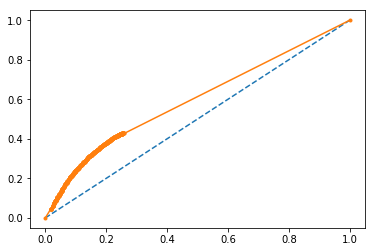

In [52]:
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_test, y_probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr0, tpr0, marker='.')
# show the plot
pyplot.show()

<a id='feature_importance'></a>
# Feature Importance
<a href=#top>Top</a>

In [53]:
len(clf0.feature_importances_)

34

NameError: name 'plt' is not defined

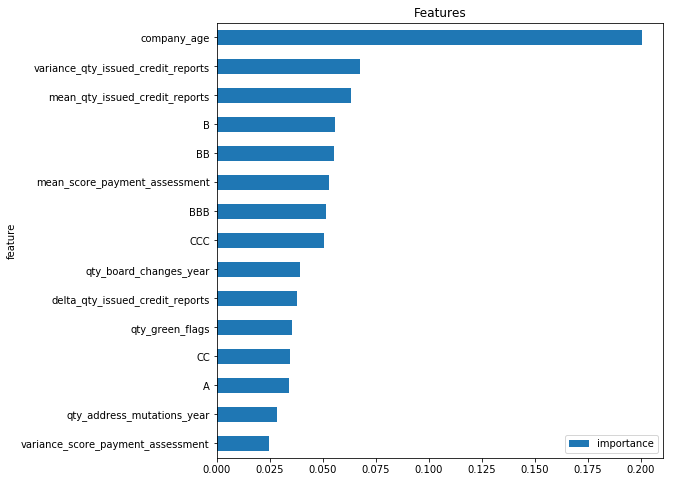

In [54]:
feat_imp = pd.DataFrame({'importance':clf0.feature_importances_})    
feat_imp['feature'] = x_train[features_in_model].columns

feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:15]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Features', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

<a id='balancedata'></a>
## Balance Data:

<a href=#top>Top</a>

In [39]:
train_all = x_train.copy()

In [40]:
train_all.columns

Index(['has_name_change', 'delta_qty_issued_credit_reports',
       'delta_score_payment_assessment', 'code_legal_form_has_changed',
       'SBI_has_changed', 'company_age', 'qty_green_flags', 'qty_orange_flags',
       'qty_red_flags', 'A', 'AA', 'AAA', 'B', 'BB', 'BBB', 'C', 'CC', 'CCC',
       'D', 'NR', 'code_legal_form_group_1', 'code_legal_form_group_2',
       'SBI_group_1', 'SBI_group_2', 'is_discontinued_any',
       'has_financial_calamity', 'mean_qty_issued_credit_reports',
       'mean_score_payment_assessment', 'qty_address_mutations_year',
       'qty_started_names_year', 'qty_stopped_names_year',
       'qty_board_changes_year', 'variance_qty_issued_credit_reports',
       'variance_score_payment_assessment'],
      dtype='object')

In [41]:
train_all['has_relocated_next_year'] = y_train

In [42]:
len(x_train.columns)

34

In [43]:
train_all.shape

(670456, 35)

In [44]:
train_all.has_relocated_next_year.value_counts() / train_all.shape[0]

0    0.962831
1    0.037169
Name: has_relocated_next_year, dtype: float64

In [45]:
# Choose desired class breakdown
fraction_majority = 0.50

In [46]:
num_minority = train_all[train_all['has_relocated_next_year']==True].shape[0]

num_majority = fraction_majority * num_minority / (1 - fraction_majority)

num_minority, int(num_majority), num_majority, num_majority/(num_majority + num_minority)

(24920, 24920, 24920.0, 0.5)

In [47]:
# Separate majority and minority classes
df_majority = train_all[train_all.has_relocated_next_year==False]
df_minority = train_all[train_all.has_relocated_next_year==True]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=int(num_majority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.has_relocated_next_year.value_counts()

1    24920
0    24920
Name: has_relocated_next_year, dtype: int64

In [48]:
df_downsampled.has_relocated_next_year.value_counts()/df_downsampled.shape[0]

1    0.5
0    0.5
Name: has_relocated_next_year, dtype: float64

In [49]:
df_downsampled.shape

(49840, 35)

## Remove NaNs from Balanced Dataset:

In [50]:
data_to_model = df_downsampled

In [51]:
data_to_model.shape

(49840, 35)

## Check for NAs

Drop rows with NA:

For other options: https://machinelearningmastery.com/handle-missing-data-python/

In [52]:
data_to_model.isnull().values.any()

False

In [53]:
print(data_to_model.isnull().sum())

has_name_change                       0
delta_qty_issued_credit_reports       0
delta_score_payment_assessment        0
code_legal_form_has_changed           0
SBI_has_changed                       0
company_age                           0
qty_green_flags                       0
qty_orange_flags                      0
qty_red_flags                         0
A                                     0
AA                                    0
AAA                                   0
B                                     0
BB                                    0
BBB                                   0
C                                     0
CC                                    0
CCC                                   0
D                                     0
NR                                    0
code_legal_form_group_1               0
code_legal_form_group_2               0
SBI_group_1                           0
SBI_group_2                           0
is_discontinued_any                   0


Drop rows with NA:

In [54]:
data_to_model.dropna(inplace=True)

# summarize the number of rows and columns in the dataset
print(data_to_model.shape)

(49840, 35)


In [55]:
data_to_model.isnull().values.any()

False

<a id='dt_rebalance'></a>

# Decision Tree on Re-balanced data

<a href=#top>Top</a>

In [56]:
x_re_train, x_re_test, y_re_train, y_re_test = train_test_split(data_to_model[features_in_model], 
                                                                data_to_model.has_relocated_next_year, 
                                                    test_size=0.25, random_state=0)

y_re_train=y_re_train.astype('int')
y_re_test=y_re_test.astype('int')

### clf = tree.DecisionTreeClassifier()

clf.fit(x_re_train, y_re_train)

In [71]:
# Train accuracy:
measure_performance(x_re_train,y_re_train,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.910 



In [72]:
# Test accuracy:
measure_performance(x_re_test,y_re_test,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.629 



## Write out model:

In [73]:
filename = 'models/DT_2017defaults_balanced_more1employee.sav'
pickle.dump(clf, open(filename, 'wb'))

## Tuning:

In [74]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [232]:
tree.DecisionTreeClassifier?

In [76]:
from sklearn.metrics import cohen_kappa_score, make_scorer

kappa_scorer = make_scorer(cohen_kappa_score)

parameters = {'max_depth':[5,6,7,8,9,10,15,20,25], 
              'min_samples_split':[5,10,15,20], 
              'min_samples_leaf':[2,3,5],
              'max_features': [5, 10, 13, 15, 20, 25, 30, 32, None]}
clfKappa = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4, scoring=kappa_scorer)
clfKappa.fit(X=x_re_train, y=y_re_train)
clfDT_Kappa = clfKappa.best_estimator_
print (clfKappa.best_score_, clfKappa.best_params_)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.356596912371958 {'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 10, 'max_depth': 10}


In [77]:
filename = 'models/DT_2017md10_mss15_msl3_mf10_balanced_more1employee.sav'
pickle.dump(clfDT_Kappa, open(filename, 'wb'))

In [78]:
# Grid searched DT accuracy:
measure_performance(x_re_train,y_re_train, clfDT_Kappa, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.689 



## Accuracy on Test Set:

<a href=#top>Top</a>

In [79]:
y_re_pred=clfDT_Kappa.predict(x_re_test)

In [80]:
cnf_matrix = metrics.confusion_matrix(y_re_test, y_re_pred)
cnf_matrix

array([[3287, 2961],
       [1068, 5144]])

In [81]:
y_re_pred=clfDT_Kappa.predict(x_re_test)

score=metrics.accuracy_score(y_re_test, y_re_pred)


# Get probabilities
y_re_probs = clfDT_Kappa.predict_proba(x_re_test)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_re_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_re_test, y_re_pred)
cr=metrics.classification_report(y_re_test, y_re_pred)

score, auc, kappa

(0.6766452648475121, 0.7412453247112482, 0.3538523913902485)

In [82]:
print(cr)

              precision    recall  f1-score   support

           0       0.75      0.53      0.62      6248
           1       0.63      0.83      0.72      6212

   micro avg       0.68      0.68      0.68     12460
   macro avg       0.69      0.68      0.67     12460
weighted avg       0.69      0.68      0.67     12460



<a id='plot'></a>
# Plot

<a href=#top>Top</a>


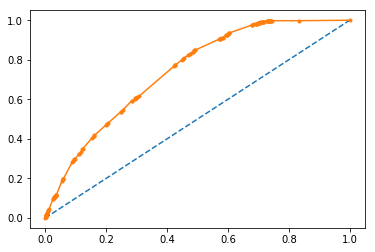

In [83]:
fpr, tpr, thresholds = metrics.roc_curve(y_re_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

<a id='verify_unbalanced'></a>
## Verify on Un-balanced test set:

<a href=#top>Top</a>

In [84]:
y_re_pred_unbalance=clfDT_Kappa.predict(x_test)

In [85]:
y_re_pred_unbalance.shape

(167615,)

In [86]:
sum(y_test) / len(y_test), sum(y_test==0) / len(y_test) 

(0.036834412194612656, 0.9631655878053873)

In [87]:
sum(y_re_pred_unbalance==1) / len(y_re_pred_unbalance), sum(y_re_pred_unbalance!=1) / len(y_re_pred_unbalance)

(0.4884049756883334, 0.5115950243116666)

In [88]:
cnf_matrix = metrics.confusion_matrix(y_test, y_re_pred_unbalance)
cnf_matrix

array([[84698, 76743],
       [ 1053,  5121]])

In [89]:
score=metrics.accuracy_score(y_test, y_re_pred_unbalance)

# Get probabilities
y_re_probs = clfDT_Kappa.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_test, y_re_pred_unbalance)
cr=metrics.classification_report(y_test, y_re_pred_unbalance)

In [90]:
score, auc, kappa

(0.5358649285565135, 0.743578198453354, 0.05135130361097917)

In [91]:
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.52      0.69    161441
           1       0.06      0.83      0.12      6174

   micro avg       0.54      0.54      0.54    167615
   macro avg       0.53      0.68      0.40    167615
weighted avg       0.95      0.54      0.66    167615



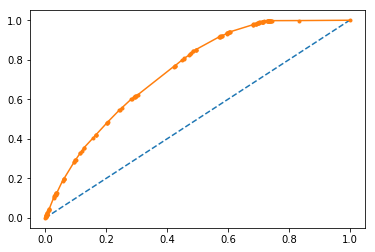

In [92]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

<a id='re_train'></a>
# Re-Train Optimal Tree on Unbalanced data 
<a href=#top>Top</a>

In [76]:
clf0

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [77]:
tree.DecisionTreeClassifier?

In [93]:
#'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 10, 'max_depth': 10

clf1 = tree.DecisionTreeClassifier(max_depth=10, min_samples_split=15, min_samples_leaf=3, max_features=10)
clf1.fit(x_train, y_train)  

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=15,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [94]:
measure_performance(x_train,y_train,clf1, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.963 



In [95]:
y_predII=clf1.predict(x_test)

In [96]:
cnf_matrix = metrics.confusion_matrix(y_test, y_predII)
cnf_matrix

array([[161418,     23],
       [  6172,      2]])

In [97]:
print('Accuracy of Decision Tree classifier on test set: {:.4f}'.format(clf1.score(x_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.9630


In [98]:
score=metrics.accuracy_score(y_test, y_predII)

# Get probabilities
y_probs = clf1.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_probs = y_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_probs)

kappa = metrics.cohen_kappa_score(y_test, y_predII)
cr=metrics.classification_report(y_test, y_predII)

In [99]:
score, auc, kappa

(0.9630403006890791, 0.7458556554011784, 0.00034826920549158036)

In [100]:
print(cr)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    161441
           1       0.08      0.00      0.00      6174

   micro avg       0.96      0.96      0.96    167615
   macro avg       0.52      0.50      0.49    167615
weighted avg       0.93      0.96      0.95    167615



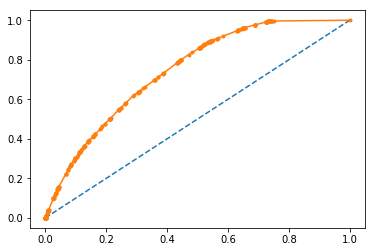

In [101]:
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_test, y_probs)

# plot no skill

pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr0, tpr0, marker='.')
# show the plot
pyplot.show()

<a id='feature_importance2'></a>
## Feature Importance
<a href=#top>Top</a>

NameError: name 'plt' is not defined

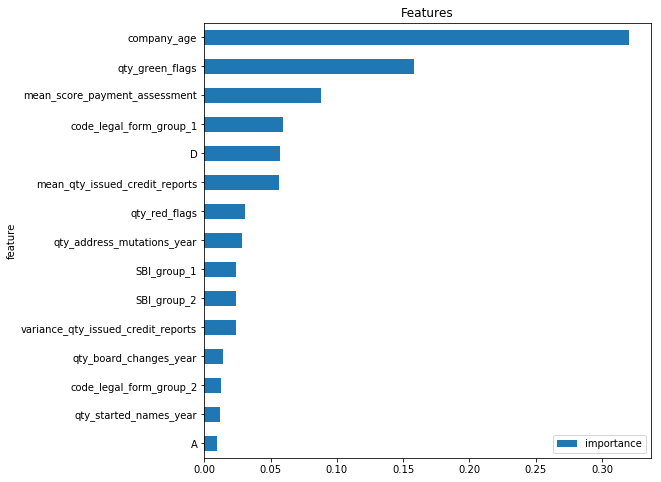

In [102]:
feat_imp = pd.DataFrame({'importance':clf1.feature_importances_})    
feat_imp['feature'] = x_train[features_in_model].columns

feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:15]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Features', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

<a href=#top>Top</a>
# Feature Importance of Final Model:
<a id='feature_importance_final'></a>

In [59]:
importances = model.feature_importances_

In [60]:
len(importances)

34

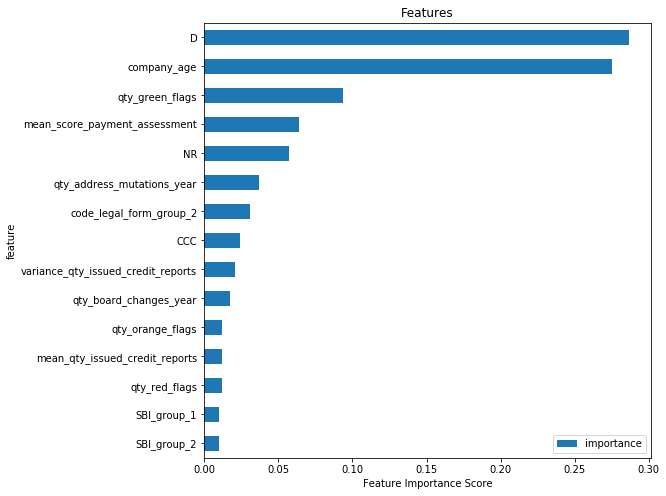

In [61]:
feat_imp = pd.DataFrame({'importance':importances})    
feat_imp['feature'] = x_train[features_in_model].columns

feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:15]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Features', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

<a id='lift_chart_final'></a>
# Lift Chart  of Final Model:
<a href=#top>Top</a>

In [40]:
x_re_train, x_re_test, y_re_train, y_re_test = train_test_split(data_to_model[features_in_model], 
                                                                data_to_model.has_relocated_next_year, 
                                                    test_size=0.25, random_state=0)

In [41]:
x_re_test.shape

(209518, 34)

In [42]:
x_re_test

,has_name_change,delta_qty_issued_credit_reports,delta_score_payment_assessment,code_legal_form_has_changed,SBI_has_changed,company_age,qty_green_flags,qty_orange_flags,qty_red_flags,A,...,is_discontinued_any,has_financial_calamity,mean_qty_issued_credit_reports,mean_score_payment_assessment,qty_address_mutations_year,qty_started_names_year,qty_stopped_names_year,qty_board_changes_year,variance_qty_issued_credit_reports,variance_score_payment_assessment
1912428,False,0.0,-8.0,False,False,6.0,6.0,0.0,0.0,6.0,...,False,False,0.000000,24.000000,1.0,0.0,0.0,1.0,0.000000,19.200000
1188074,False,0.0,0.0,False,False,7.0,12.0,0.0,0.0,0.0,...,False,False,0.000000,28.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
1255035,False,0.0,0.0,False,False,6.0,12.0,0.0,0.0,0.0,...,False,False,0.000000,28.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
1918503,False,0.0,0.0,False,False,0.0,5.0,0.0,0.0,0.0,...,False,False,0.000000,28.000000,1.0,0.0,0.0,1.0,0.000000,0.000000
708130,False,0.0,0.0,False,False,15.0,0.0,0.0,12.0,0.0,...,False,False,0.000000,28.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
1115544,False,0.0,0.0,False,False,8.0,0.0,0.0,12.0,0.0,...,False,False,0.000000,28.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
243556,False,1.0,2.0,False,False,27.0,3.0,6.0,3.0,0.0,...,False,False,0.166667,22.583333,0.0,0.0,0.0,0.0,0.151515,0.810606
55169,False,0.0,0.0,False,False,44.0,12.0,0.0,0.0,0.0,...,False,False,0.000000,28.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
1788050,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
667435,False,0.0,0.0,False,False,16.0,0.0,0.0,12.0,0.0,...,False,False,0.000000,20.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [58]:
filename = 'models/DT_2017md10_mss15_msl3_mf10_balanced_more1employee.sav'
model = pickle.load(open(filename, "rb"))

In [63]:
y_probs = model.predict_proba(x_re_test)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


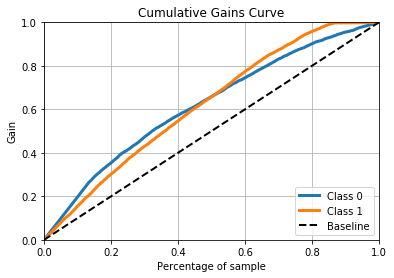

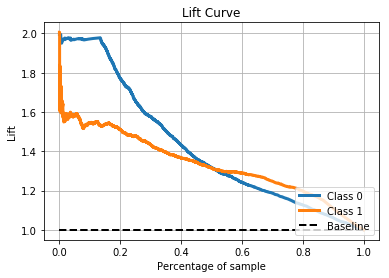

In [64]:
skplt.metrics.plot_cumulative_gain(y_re_test, y_probs)
plt.show()
skplt.metrics.plot_lift_curve(y_re_test, y_probs)
plt.show()

<a id='confusionmatrixplot'></a>
# Confusion Matrix Plot:
<a href=#top>Top</a>

In [66]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [67]:
y_re_pred= model.predict(x_re_test)
cnf_matrix = metrics.confusion_matrix(y_re_test, y_re_pred)
cnf_matrix

array([[3287, 2961],
       [1068, 5144]])

Confusion matrix, without normalization
[[3287 2961]
 [1068 5144]]


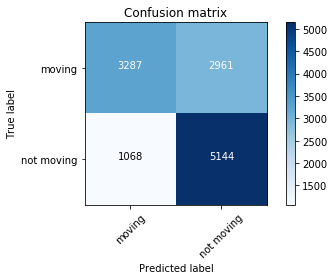

In [68]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['moving', 'not moving'],
                      title='Confusion matrix')

<a id='bottom'></a>

<a href=#top>Top</a>
# End